# Basic MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of a basic MCMC algorithm.
This example takes inspiration from [this blog post](https://towardsdatascience.com/bayesian-inference-and-markov-chain-monte-carlo-sampling-in-python-bada1beabca7) with some simplifications and notation updated to align with the accompanying tutorial.

### Imports

In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm
from scipy import stats
# visulisation function
from functions.visualisations import histogram_trace

## Define the functions required for MCMC sampling

We will start with the simplest example, sampling the posterior of a single parameter.
In this example, we are trying to obtain information about the probability of success given some data of `k` successes in `n` trials using an uninformative prior.

This type of problem is represented by a binomial distribution and we will be solving for the posterior distribution of parameter `p` (probability of success) in this distribution.

First, we need to define the likelihood function given our data (`k`,`n`).

In [2]:
# First define our likelihood function which will be dependent on provided `data`
def generate_likelihood(k, n):
    '''
    Given the data of k successes in n trials, return a likelihood function which 
    evaluates the probability that a single success (p) is query_prob for any given 
    query_prob (between 0 and 1).
    This is defined by a binomial distribution. 
    See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html
    '''
    def likelihood(query_prob):
        return stats.binom.pmf(k, n, query_prob)
    return likelihood

## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution
- We will use an informative, uniform prior - $Pr(p) = 1$ for $p \in [0,1]$
- With this symmetric prior and the proposal `p` between 0 and 1, the contribution of the proposal distribution to the MH acceptance ratio is always:

$$\frac{q(x_i \mid x')}{q(x' \mid x_i)} = 1$$

- We therefore only need to compare the likelihood of the proposed and current sample 
$$ \frac{P(x')}{P(x_i)} = ?$$

In [3]:
## MCMC Settings and Setup
n_samples = 10000 # number of samples to draw from the posterior
burn_in = 2500 # number of samples to discard before recording draws from the posterior

# specify our `data` for this example ensuring k <= n
binom_k = 50 # number of successes
binom_n = 100 # in n trials

x = random.uniform(0, 1) # initialise a value of x0
count = 0 # count the number of accepted samples

In [4]:
# first, given the `data` provided we need to create our likelihood function
likelihood_function = generate_likelihood(binom_k, binom_n)

# create an array of NaNs to fill with our samples
p_posterior = np.full(n_samples, np.nan) 

print('Generating {} MCMC samples from the posterior:'.format(n_samples))
# now we can start the MCMC sampling loop
for ii in tqdm(np.arange(n_samples)):
    # Sample a value uniformly from 0 to 1 as a proposal
    x_new = random.uniform(0, 1)

    # Calculate the Metrpolis-Hastings acceptance probability based on the prior 
    # (can be ignored in this case) and likelihood
    prior_ratio = 1 # for this simple example as discussed above
    likelihood_ratio = likelihood_function(x_new) / likelihood_function(x)
    alpha = np.min([1, likelihood_ratio * prior_ratio])

    # Here we use a random draw from a uniform distribution between 0 and 1 as a 
    # method of accepting the new proposal with a probability of alpha
    # (i.e., accept if u < alpha)
    u = random.uniform(0, 1)
    if u < alpha:
        x = x_new # then update the current sample to the propoal for the next iteration
        count += 1 # add to the count of accepted samples

    # Store the current sample
    p_posterior[ii] = x
print('Done')

Generating 10000 MCMC samples from the posterior:


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1902.98it/s]

Done


## Analyse the results
Plot the posterior distribution and trace

In [5]:
# print(results, 'results')
per_accept = (count/n_samples)*100
print('{:.3f} % accepted'.format(per_accept))
posterior_mean = np.mean(p_posterior[burn_in:])
print('{:.3f} mean value of posterior'.format(posterior_mean))

16.090 % accepted
0.500 mean value of posterior


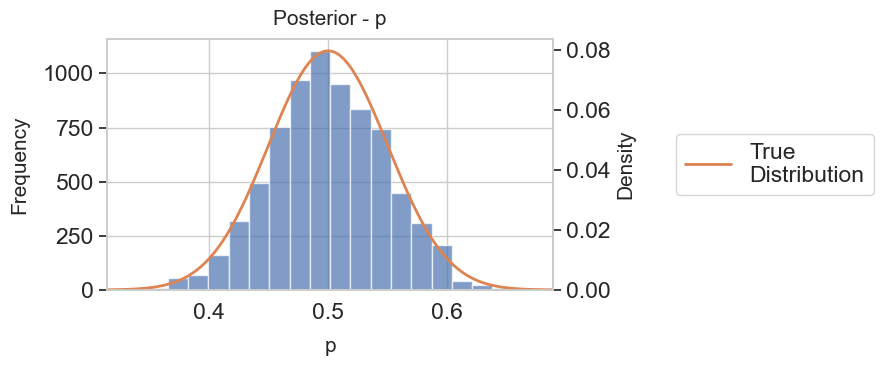

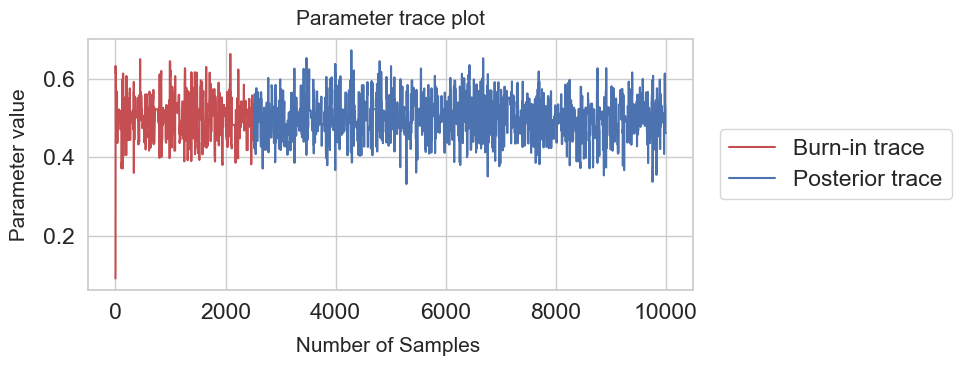

In [6]:
histogram_trace(
    p_posterior, 
    true_posterior = np.vstack([np.linspace(0,1,1000),likelihood_function(np.linspace(0,1,1000))]).T, 
    burn_in = burn_in,
    title='Posterior - p',
    param_name = 'p',
    # fname='figures/02-Basic-MCMC'  
)